# Overview

In [1]:
## The underlying idea behind GAN is that it contains two neural networks that compete against each other in a 
## zero-sum game framework, i.e. generator and a discriminator.

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import datetime
import os
import glob
import random
from PIL import Image

In [4]:
# Paths
INPUT_DATA_DIR = "simpsons-faces/cropped/" # Path to the folder with input images.

(9877, 128, 128, 3)


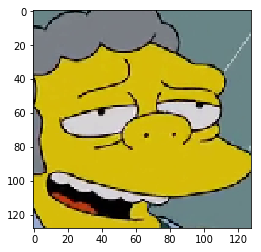

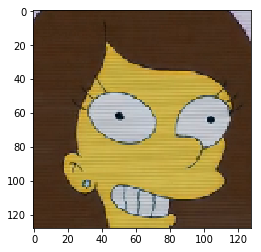

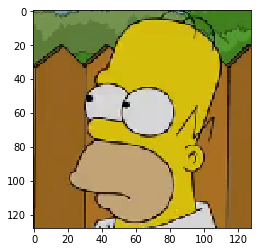

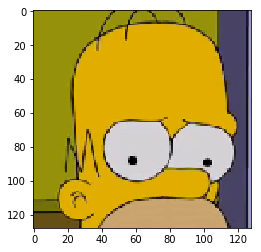

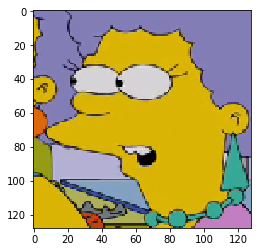

In [5]:
## Loading the images

IMAGE_SIZE = 128
filelist = glob.glob('simpsons-faces/cropped/*.png')

input_imgs = np.asarray([np.asarray(Image.open(file).resize(
                (IMAGE_SIZE, IMAGE_SIZE))) for file in filelist])

print(input_imgs.shape)

np.random.shuffle(input_imgs)

for ix in range(5):
    plt.imshow(input_imgs[ix])
    plt.show()

In [6]:
## NORMALIZING THE DATA [-1,1]

input_imgs = (input_imgs.astype('float32') - 127.5)/127.5   # 127.5 is the middlmost val for any pixel...0 to 255
print(np.min(input_imgs))
print(np.max(input_imgs))

-1.0
1.0


In [7]:
# Hyperparameters

IMAGE_SIZE = 128
NOISE_SIZE = 100
BATCH_SIZE = 64
HALF_BATCH = 32
EPOCHS = 300
EPSILON = 0.00005
NO_OF_BATCHES = math.ceil(input_imgs.shape[0]/float(BATCH_SIZE))
adam = Adam(lr=2e-4, beta_1=0.5)  

In [8]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

In [9]:
## DEFINING THE GENERATOR MODEL

# 8x8x1024
generator = Sequential()
generator.add(Dense(8*8*1024, input_shape=(NOISE_SIZE,)))
generator.add(Reshape((8,8,1024)))
generator.add(LeakyReLU(0.2))                     ## adding non-linearity

# 8x8x1024 -> 16x16x512
generator.add(Conv2DTranspose(512, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(BatchNormalization(epsilon=EPSILON))
generator.add(LeakyReLU(0.2))

# 16x16x512 -> 32x32x256
generator.add(Conv2DTranspose(256, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(BatchNormalization(epsilon=EPSILON))
generator.add(LeakyReLU(0.2))

# 32x32x256 -> 64x64x128
generator.add(Conv2DTranspose(128, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(BatchNormalization(epsilon=EPSILON))
generator.add(LeakyReLU(0.2))

# 64x64x128 -> 128x128x64
generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(BatchNormalization(epsilon=EPSILON))
generator.add(LeakyReLU(0.2))

# 128x128x64 -> 128x128x3
generator.add(Conv2DTranspose(3,kernel_size=(5,5),padding='same',strides=(1,1),activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6619136   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       3

In [10]:
## DEFINING THE DISCRIMINATOR MODEL that accepts a img of 28,28,3

# 128*128*3 -> 64x64x64
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(128,128,3)))
discriminator.add(BatchNormalization(epsilon=EPSILON))
## we use striding in place of max pooling in case of gans
discriminator.add(LeakyReLU(0.2))

# 64x64x64-> 32x32x128
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(BatchNormalization(epsilon=EPSILON))
discriminator.add(LeakyReLU(0.2))

# 32x32x128 -> 16x16x256
discriminator.add(Conv2D(256,(5,5),strides=(2,2),padding='same'))
discriminator.add(BatchNormalization(epsilon=EPSILON))
discriminator.add(LeakyReLU(0.2))

# 16x16x256 -> 16x16x512
discriminator.add(Conv2D(512,(5,5),strides=(1,1),padding='same'))
discriminator.add(BatchNormalization(epsilon=EPSILON))
discriminator.add(LeakyReLU(0.2))

# 16x16x512 -> 8x8x1024
discriminator.add(Conv2D(1024,(5,5),strides=(2,2),padding='same'))
discriminator.add(BatchNormalization(epsilon=EPSILON))
discriminator.add(LeakyReLU(0.2))

## Flattening
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)      

In [11]:
discriminator.trainable = False                     ## Discriminator is frozen
gan_input = Input(shape=(NOISE_SIZE,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

## FUNCTIONAL API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy', optimizer=adam)

In [12]:
!mkdir images
!mkdir model

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘model’: File exists


In [13]:
def save_imgs(epochs,samples=4):
    
    noise = np.random.normal(0,1,size=(samples,NOISE_SIZE))
    gen_imgs = generator.predict(noise)
    gen_imgs = gen_imgs.reshape(samples,128,128,3)
    
    plt.figure(figsize=(128,128))
    for i in range(samples):
        
        plt.subplot(2,2,i+1)
        plt.imshow(gen_imgs[i], interpolation='nearest', cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('./images/gan_output{0}.png'.format(epoch+1))
    plt.show()

In [15]:
def show_samples(epoch, samples=5):
    
    noise = np.random.normal(0,1,size=(samples,NOISE_SIZE))
    gen_imgs = generator.predict(noise)
    gen_imgs = gen_imgs.reshape(samples,128,128,3)
    
    figure, axes = plt.subplots(1, len(gen_imgs), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = gen_imgs[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [14]:
## Training

def train(get_batches):
    
    d_losses = []
    g_losses = []
    
    for epoch in range(EPOCHS):
        
        disc_loss = 0.
        gen_loss = 0.
        
        for batch_images in get_batches:
            
            ## Step-1 Training the Discriminator
            ## 50% real data, 50% fake data

            ## REAL DATA
            real_imgs = batch_images

            ## FAKE DATA
            noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))   ## Gaussian distributed Noise vector
            fake_imgs = generator.predict(noise)                    ## generating a fake img out of noise

            ## LABELS for real and fake imgs
            real_y = np.ones((BATCH_SIZE,1))*0.9   ## 90% sure that real ones are reals...one sided label smoothing
            fake_y = np.zeros((BATCH_SIZE,1))

            ## Train the Discriminator
            disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
            disc_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

            disc_loss += (disc_loss_fake + disc_loss_real)/2    ## equally weighted total loss for full epoch

            ## Training the Generator, Step-2, Frozen Discriminator
            noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))
            grnd_truth_y = np.ones((BATCH_SIZE,1))
            gen_loss += model.train_on_batch(noise, grnd_truth_y)
            
        print("Epoch%d :: Disc Loss %.4f -- Gen Loss %.4f" %((epoch+1),disc_loss/NO_OF_BATCHES,gen_loss/NO_OF_BATCHES))
        d_losses.append(disc_loss/NO_OF_BATCHES)
        g_losses.append(gen_loss/NO_OF_BATCHES)

        if (epoch+1)%50 == 0:
            generator.save('./model/gan_generator{0}.h5'.format(epoch+1))
            show_samples(epoch)

In [15]:
train(get_batches(input_imgs))

ResourceExhaustedError: OOM when allocating tensor with shape[64,128,128,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:BiasAdd] name: model/sequential/conv2d_transpose_3/BiasAdd/

In [ ]:
## TRAINING LOOP
d_losses = []
g_losses = []

for epoch in range(EPOCHS):
    
    disc_loss = 0.
    gen_loss = 0.
    
    ## Mini batch SGD
    for step in range(NO_OF_BATCHES):
        
        ## Step-1 Training the Discriminator
        ## 50% real data, 50% fake data
        
        ## REAL DATA
        idx = np.random.randint(0,input_imgs.shape[0],HALF_BATCH)  ## randint(low,high,no_of_numbers)
        real_imgs = input_imgs[idx]                                ## real images corr to the real indices
        
        ## FAKE DATA
        noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_SIZE))   ## Gaussian distributed Noise vector
        fake_imgs = generator.predict(noise)                        ## generating a fake img out of noise
        
        ## LABELS for real and fake imgs
        real_y = np.ones((HALF_BATCH,1))*0.9      ## 90% sure that real ones are reals...one sided label smoothing
        fake_y = np.zeros((HALF_BATCH,1))
        
        ## Train the Discriminator
        disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        disc_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        
        disc_loss += (disc_loss_fake + disc_loss_real)/2             ## equally weighted total loss for full epoch
        
        ## Training the Generator, Step-2, Frozen Discriminator
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))    ## complete 256 imgs
        grnd_truth_y = np.ones((BATCH_SIZE,1))
        gen_loss += model.train_on_batch(noise, grnd_truth_y)
        
    print("Epoch%d :: Disc Loss %.4f -- Gen Loss %.4f" %((epoch+1),disc_loss/NO_OF_BATCHES,gen_loss/NO_OF_BATCHES))
    d_losses.append(disc_loss/NO_OF_BATCHES)
    g_losses.append(gen_loss/NO_OF_BATCHES)
    
    if (epoch+1)%5 == 0:
        generator.save('./model/gan_generator{0}.h5'.format(epoch+1))
        save_imgs1(epoch)

In [10]:
150/24

6.25

In [5]:
256*2*2*2*2*2

8192